In [41]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from imutils import paths
import cv2

from tensorflow.keras.applications import ResNet50,ResNet101
from tensorflow.keras.layers import AveragePooling2D,GlobalAveragePooling2D,Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.applications.efficientnet import preprocess_input
from align_faces import warp_and_crop_face, get_reference_facial_points
from mtcnn.detector import MtcnnDetector
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score


In [15]:
dataset = 'dataset'

imagePaths = list(paths.list_images(dataset))

In [16]:
len(imagePaths)

13800

In [17]:
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)

In [18]:
IMAGE_RESIZE = 224
BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100
EARLY_STOP_PATIENCE = 3
RESNET50_POOLING_AVERAGE = 'avg'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

In [19]:
train_generator = data_generator.flow_from_directory(
    'dataset',
    target_size=(IMAGE_RESIZE, IMAGE_RESIZE),
    batch_size=BATCH_SIZE_TRAINING,
    subset='training',
    class_mode='categorical')
validation_generator = data_generator.flow_from_directory(
    'dataset',
    target_size=(IMAGE_RESIZE, IMAGE_RESIZE),
    batch_size=BATCH_SIZE_VALIDATION,
    subset='validation',
    class_mode='categorical')

Found 11040 images belonging to 2 classes.
Found 2760 images belonging to 2 classes.


In [20]:
(BATCH_SIZE_TRAINING, len(train_generator), BATCH_SIZE_VALIDATION, len(validation_generator))

(100, 111, 100, 28)

In [75]:

# Đường dẫn đến mô hình đã được lưu
model_path = 'resnet101_w3.model'


In [76]:

# Tải mô hình
loaded_model = tf.keras.models.load_model(model_path)

In [77]:
test_dir = 'data/test'

test_generator = data_generator.flow_from_directory(
    directory=test_dir,
    target_size=(IMAGE_RESIZE, IMAGE_RESIZE),
    batch_size=1,
    class_mode=None,
    shuffle=True,
    seed=123
)

Found 25 images belonging to 2 classes.


In [78]:
test_generator.reset()

pred = loaded_model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)

predicted_class_indices = np.argmax(pred, axis = 1)

C:\Users\acer\AppData\Local\Temp\ipykernel_26328\463843924.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = loaded_model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)


25/25 [==============================] - 12s 408ms/step


data/test/with_mask\with_mask_1.jpg
data/test/with_mask\with_mask_10.jpg
data/test/with_mask\with_mask_11.jpg
data/test/with_mask\with_mask_12.jpg
data/test/with_mask\with_mask_13.jpg
data/test/with_mask\with_mask_2.jpg
data/test/with_mask\with_mask_3.jpg
data/test/with_mask\with_mask_4.jpg
data/test/with_mask\with_mask_5.jpg
data/test/with_mask\with_mask_6.jpg
data/test/with_mask\with_mask_7.jpg
data/test/with_mask\with_mask_8.jpg
data/test/with_mask\with_mask_9.jpg
data/test/without_mask\without_mask_1.jpg
data/test/without_mask\without_mask_10.jpg
data/test/without_mask\without_mask_11.jpg
data/test/without_mask\without_mask_12.jpg
data/test/without_mask\without_mask_2.jpg
data/test/without_mask\without_mask_3.jpg
data/test/without_mask\without_mask_4.jpg
data/test/without_mask\without_mask_5.jpg
data/test/without_mask\without_mask_6.jpg
data/test/without_mask\without_mask_7.jpg
data/test/without_mask\without_mask_8.jpg
data/test/without_mask\without_mask_9.jpg


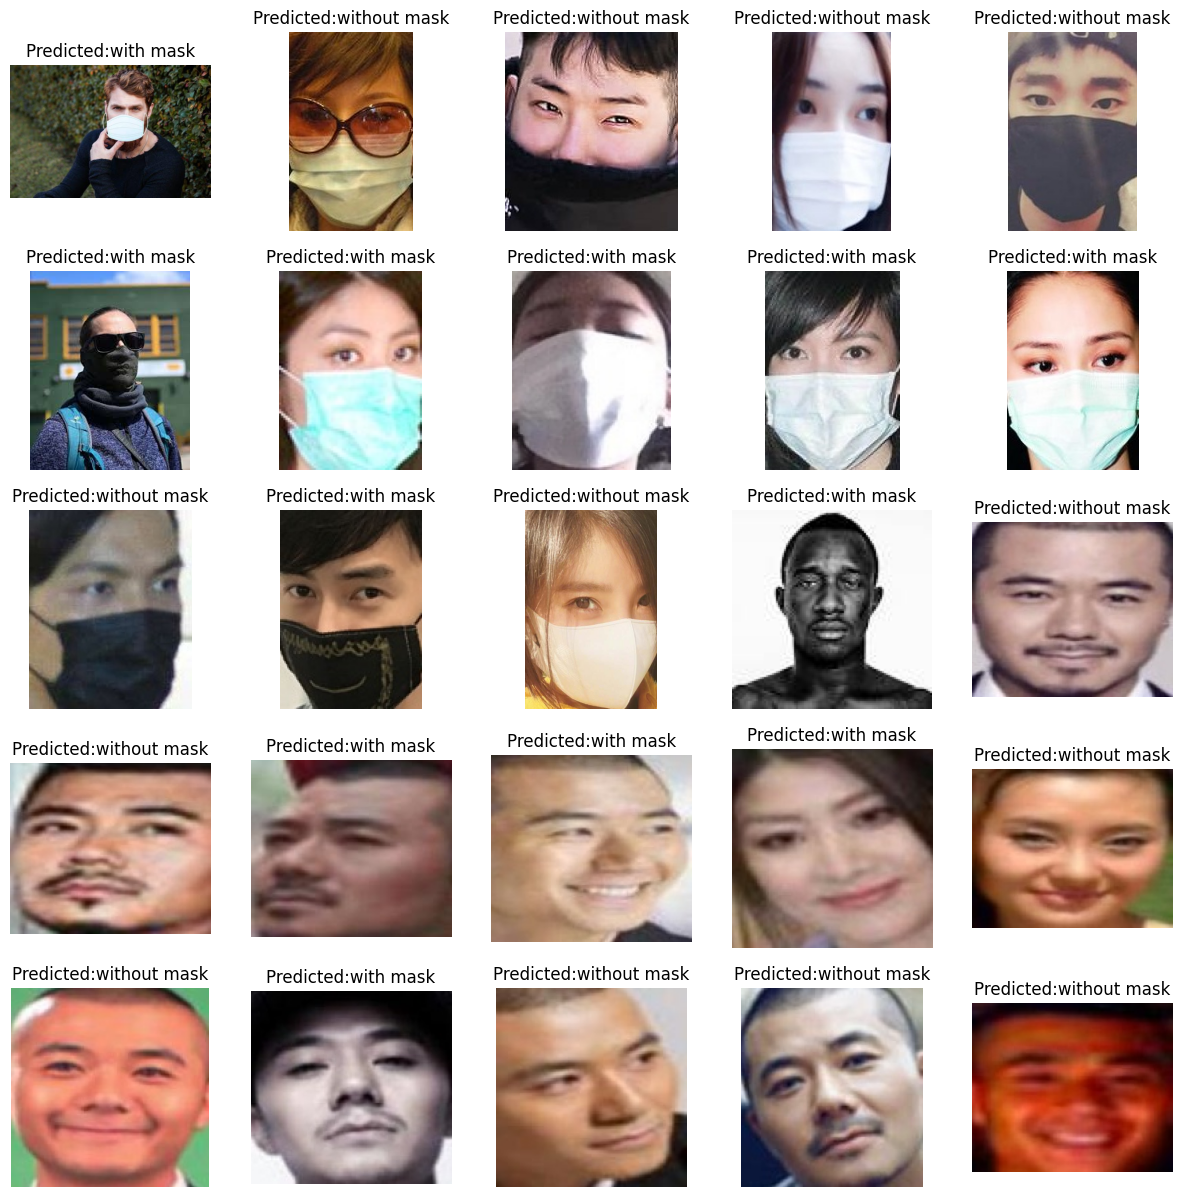

In [79]:
f, ax = plt.subplots(5, 5, figsize = (15, 15))

for i in range(0,25):
   # print(predicted_class_indices[i], test_generator.filenames[i])
    print(test_dir + '/'+ test_generator.filenames[i])
    imgBGR = cv2.imread(test_dir + '/'+ test_generator.filenames[i])
    # print(imgBGR)
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)

    # a if condition else b
    predicted_class = "without mask" if predicted_class_indices[i] else "with mask"

    ax[i//5, i%5].imshow(imgRGB)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(predicted_class))

plt.show()

In [80]:
detector = MtcnnDetector()

def face_detection(img, output_size, align = True):
    """Nếu align == True thì sẽ có thêm bước Face Alignment sau khi nhận diện gương mặt,
        ngược lại thì không có thêm bước này"""
    # Nhận diện gương mặt
    boxes, facial5points = detector.detect_faces(img)

    # Tiến hành Alignment
    if align == True:
        if len(facial5points) != 0:
            facial5points = np.reshape(facial5points[0], (2, 5))

            default_square = True
            inner_padding_factor = 0.25
            outer_padding = (0, 0)

            ## Yêu cầu 10:
            ## VIẾT CODE Ở ĐÂY:

            # sử dụng hàm get_reference_facial_points
            reference_5pts = get_reference_facial_points(
                output_size, inner_padding_factor, outer_padding, default_square)

            # sử dụng hàm warp_and_crop_face
            face = warp_and_crop_face(img, facial5points, reference_pts = reference_5pts, crop_size = output_size)

    # Không Alignment
    else:
        (h,w) = img.shape[:2]
        if len(boxes) != 0:
            for box in boxes:
                (startX, startY, endX, endY) = box[:4].astype('int')
                (startX, startY) = (max(0, startX),max(0, startY))
                (endX, endY) = (min(w-1, endX), min(h-1, endY))
                face = img[startY:endY, startX:endX]
                face = cv2.resize(face, output_size)

    return face

In [81]:
test_X_align = []

In [82]:
choose = []

for i in range(len(test_generator.filepaths)):
    img = cv2.imread(test_generator.filepaths[i])
    try:
        # Tiến hành nhận diện gương mặt kết hợp với Face Alignement, trả về kích thươc ảnh là 224x224
        #Perform face detection with alignment
        face = face_detection(img,(224, 224), align=True)
        test_X_align.append(face)
        choose.append(i)
    except:
        # Nếu tấm ảnh không nhận diện được thì chúng ta sẽ bỏ qua tấm này
        continue

# Convert to numpy arrays
test_X_align = np.array(test_X_align)
choose = np.array(choose)

In [83]:
# Get true labels
test_Y_true = test_generator.classes[choose]

# Make predictions
predict = loaded_model.predict(test_X_align)
predict = np.argmax(predict, axis=1)
# Calculate accuracy
accuracy = accuracy_score(test_Y_true, predict)
print("Test accuracy:", accuracy)

1/1 [==============================] - 6s 6s/step
Test accuracy: 0.8


In [84]:
def mask_detect(image):

    img = image.copy()
    (h,w) = img.shape[:2]
    boxes, facial5points = detector.detect_faces(img)
    for box in boxes:
        (startX,startY,endX,endY)=box[:4].astype('int')

        #ensure the bounding boxes fall within the dimensions of the frame
        (startX,startY)=(max(0,startX),max(0,startY))
        (endX,endY)=(min(w-1,endX), min(h-1,endY))


        #extract the face ROI, convert it from BGR to RGB channel, resize it to 224,224 and preprocess it
        face=img[startY:endY, startX:endX]
        face=cv2.resize(face,(224,224))

        (mask,withoutMask)=loaded_model.predict(face.reshape(1,224,224,3))[0]

        #determine the class label and color we will use to draw the bounding box and text
        label='Mask' if mask>withoutMask else 'No Mask'
        color=(0,255,0) if label=='Mask' else (0,0,255)

        #include the probability in the label
        label="{}: {:.2f}%".format(label,max(mask,withoutMask)*100)

        #display the label and bounding boxes
        cv2.putText(img,label,(startX,startY-10),cv2.FONT_HERSHEY_SIMPLEX,0.45,color,2)
        cv2.rectangle(img,(startX,startY),(endX,endY),color,2)

    return img

In [85]:
from imutils.video import VideoStream
import imutils

1/1 [==============================] - 0s 429ms/step


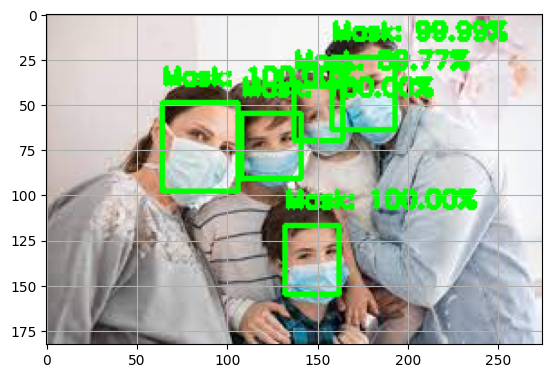

In [86]:
img = cv2.imread("family.jpg")

img = mask_detect(img)

plt.imshow(img[:, :, ::-1])
plt.grid(None)

cv2.imshow("OutPut",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [87]:
vs = cv2.VideoCapture(0)

while True:
    #grab the frame from the threaded video stream and resize it
    #to have a maximum width of 400 pixels
    frame = vs.read()[1]
    (h, w) = frame.shape[:2]
    boxes, facial5points = detector.detect_faces(frame)
    for box in boxes:
        (startX, startY, endX, endY) = box[:4].astype('int')

        #ensure the bounding boxes fall within the dimensions of the frame
        (startX, startY) = (max(0, startX),max(0, startY))
        (endX, endY) = (min(w-1, endX), min(h-1, endY))


        #extract the face ROI, convert it from BGR to RGB channel, resize it to 224,224 and preprocess it
        face = frame[startY:endY, startX:endX]
        face = cv2.resize(face,(224,224))

        (mask, withoutMask) = loaded_model.predict(face.reshape(1,224,224,3))[0]

        #determine the class label and color we will use to draw the bounding box and text
        label = 'Mask' if mask > withoutMask else 'No Mask'
        color = (0, 255, 0) if label == 'Mask' else (0, 0, 255)

        #include the probability in the label
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask)*100)

        #display the label and bounding boxes
        cv2.putText(frame, label, (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

    #show the output frame
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF

    if key == ord('q'):
        break

cv2.destroyAllWindows()

1/1 [==============================] - 0s 418ms/step
